In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import json
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from multiprocessing import Pool
from numba import cuda
import gzip

In [7]:
import pyopencl as cl
print([device.name for platform in cl.get_platforms() for device in platform.get_devices()])

['Intel(R) Arc(TM) Graphics', 'Intel(R) Core(TM) Ultra 7 155H']


In [8]:
import pyopencl as cl

platforms = cl.get_platforms()
for platform in platforms:
    devices = platform.get_devices()
    for device in devices:
        print("Platform:", platform.name)
        print("Device:", device.name)
        print("Type:", cl.device_type.to_string(device.type))

Platform: Intel(R) OpenCL Graphics
Device: Intel(R) Arc(TM) Graphics
Type: ALL | GPU
Platform: Intel(R) OpenCL
Device: Intel(R) Core(TM) Ultra 7 155H
Type: ALL | CPU


In [12]:
# Function to parse each line of the file
def parse_line(line):
    data = json.loads(line)
    return {
        "book_id": data.get("book_id"),
        "title": data.get("title"),
        "rating": data.get("ratings_count"),
        "url": data.get("url"),
        "image_url": data.get("image_url"),
        "average_rating": data.get("average_rating"),
    }


# Function to process a chunk of lines
def process_chunk(chunk):
    return [parse_line(line) for line in chunk if parse_line(line) is not None]

# Read and process the JSON file in chunks for efficiency
def load_data_in_chunks(file_path, chunk_size=100000):
    books = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        pool = Pool()  # Use multiprocessing for parsing
        while True:
            chunk = list(f.readlines(chunk_size))
            if not chunk:
                break
            books.extend(pool.map(process_chunk, [chunk]))
    pool.close()
    pool.join()
    return [item for sublist in books for item in sublist]

In [ ]:
# # Load and preprocess the dataset
# file_path = 'goodreads_books.json.gz'
# books = load_data_in_chunks(file_path)

In [13]:
books = []
with gzip.open('goodreads_books.json.gz', 'r') as f:
    for line in f:
        field = parse_line(line)
        try:
            rating = int(field["rating"])
            
        except ValueError:
            continue
        if rating > 15:
            books.append(field)

In [14]:
# Create a DataFrame
titles = pd.DataFrame(books)

In [15]:
# Convert numerical columns to numeric types
titles['rating'] = pd.to_numeric(titles['rating'], errors='coerce')
titles['average_rating'] = pd.to_numeric(titles['average_rating'], errors='coerce')

In [16]:
# Clean and preprocess the 'title' column
titles['edit_title'] = (
    titles['title']
    .str.replace('[^a-zA-Z0-9 ]', '', regex=True)
    .str.lower()
    .str.strip()
    .str.replace('\s+', ' ', regex=True)
)

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Abdul\AppData\Local\Temp\ipykernel_19952\3657185197.py:7: SyntaxWarning: invalid escape sequence '\s'
  .str.replace('\s+', ' ', regex=True)


In [17]:
# Drop rows with missing or invalid values
titles.dropna(inplace=True)

<Axes: >

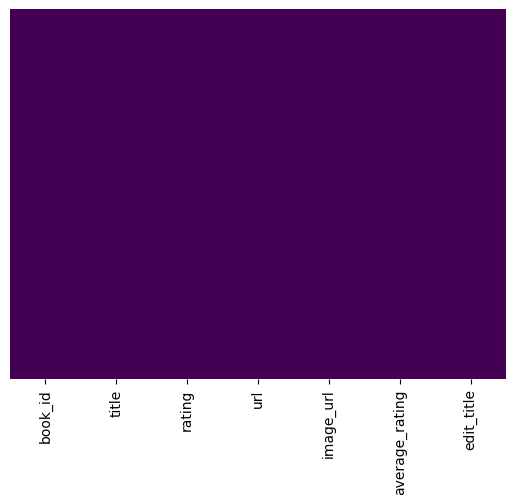

In [18]:
# Visualize missing values
sns.heatmap(titles.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [26]:
# Move TF-IDF vectorization to CPU using Numba (assuming we can't use CuPy on Intel GPU)
vector = TfidfVectorizer()
tfidf = vector.fit_transform(titles['edit_title'])

In [27]:
# Function to make the URLs clickable
def make_clickable(val):
    return f'<a target="_blank" href="{val}">click</a>'

# Function to display images
def show_image(val):
    return f'<img src="{val}" width="100" height="100">'

# Function to search for books (CPU version)
def search(query):
    query = re.sub("[^a-zA-Z0-9 ]", "", query.lower())
    query_vector = vector.transform([query]).toarray()  # Convert query to vector

    # Use CPU-based cosine similarity
    similarity = cosine_similarity(query_vector, tfidf)

    # Get top 10 most similar books
    indices = np.argpartition(similarity.flatten(), -10)[-10:]
    results = titles.iloc[indices].copy()
    results.sort_values('rating', ascending=False, inplace=True)

    return results.head(10).style.format({'url': make_clickable, 'image_url': show_image})

In [31]:
# Example search query
search('Mein Kampf')

,book_id,title,rating,url,image_url,average_rating,edit_title
324,54270,Mein Kampf,16837,click,,3.130000,mein kampf
1219923,741235,Mein Kampf,492,click,,3.130000,mein kampf
603175,642623,Mein Kampf,454,click,,3.130000,mein kampf
215294,18890332,Mein Kampf,124,click,,3.130000,mein kampf
988194,426749,Mein Kampf,59,click,,3.130000,mein kampf
934488,1239884,Mein Kampf,58,click,,3.130000,mein kampf
62630,19017887,Mein Kampf,35,click,,3.130000,mein kampf
84317,3427872,Mein Kampf,27,click,,3.130000,mein kampf
261121,7296820,Mein Kampf,23,click,,3.130000,mein kampf
1109638,8071859,Mein Kampf,22,click,,3.140000,mein kampf
